In [27]:
# ============================================
# 1. Imports
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Small helper to print DataFrames as tables with a title
def show_table(title, df_table):
    print(f"\n--- {title} ---")
    print(df_table.to_string(index=False))
    print("-" * 40)




In [47]:
# --- Fixed Helper Function ---
def show_table(title, dataframe):
    print(f"\n--- {title} ---")
    # Removed 'border=True' to fix the error
    # Added 'max_colwidth' to ensure text isn't cut off
    print(dataframe.to_string(index=True, justify='left', max_colwidth=30))
    print("-" * 50)

# ============================================
# 2. Load data
# ============================================
df = pd.read_csv("ecommerce_furniture_dataset_2024.csv")

# 2.1 Dataset info in table format
def display_dataset_info(dataframe, title="Dataset Info"):
    info_df = pd.DataFrame({
        "Column Name": dataframe.columns,
        "Data Type": dataframe.dtypes.astype(str).values,
        "Non-Null Count": dataframe.notnull().sum().values
    })
    show_table(title, info_df)

# --- EXECUTION ---

# 1. Raw Dataset Info (Matching your image)
display_dataset_info(df, "Raw Dataset Info")

# 2. Head (first 5 rows)
# Note: We use .iloc to ensure we don't grab too many columns if the file is huge
head_table = df.head(5).reset_index().rename(columns={"index": "row"})
show_table("Head (first 5 rows)", head_table)

# 3. Describe (summary stats)
describe_table = df.describe(include="all").T.reset_index().rename(columns={"index": "Column"})
show_table("Describe (summary stats)", describe_table)


--- Raw Dataset Info ---
  Column Name    Data Type  Non-Null Count
0   productTitle  object    2000          
1  originalPrice  object     487          
2          price  object    2000          
3           sold   int64    2000          
4        tagText  object    1997          
--------------------------------------------------

--- Head (first 5 rows) ---
   row productTitle                   originalPrice price     sold tagText       
0  0    Dresser For Bedroom With 9...     NaN         $46.79  600   Free shipping
1  1    Outdoor Conversation Set 4...     NaN        $169.72    0   Free shipping
2  2    Desser For Bedroom With 7 ...   $78.4         $39.46    7   Free shipping
3  3    Modern Accent Boucle Chair...     NaN        $111.99    0   Free shipping
4  4    Small Unit Simple Computer...  $48.82         $21.37    1   Free shipping
--------------------------------------------------

--- Describe (summary stats) ---
  Column         count   unique top                        

In [46]:
# ============================================
# 3. Basic cleaning and feature engineering
# ============================================

df.columns = [c.replace("\ufeff", "") for c in df.columns]

print("Columns:", df.columns)

def clean_price(col):
    return (
        df[col]
        .astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

df["originalPrice_clean"] = clean_price("originalPrice")
df["price_clean"] = clean_price("price")

df["sold"] = pd.to_numeric(df["sold"], errors="coerce")

df = df.dropna(subset=["sold"])

for col in ["originalPrice_clean", "price_clean"]:
    df[col] = df[col].fillna(df[col].median())

df["productTitle"] = df["productTitle"].astype(str).str.strip()
df["tagText"] = df["tagText"].astype(str).str.strip().fillna("Unknown")

print(df[["productTitle", "originalPrice_clean", "price_clean", "sold", "tagText"]].head())


Columns: Index(['productTitle', 'originalPrice', 'price', 'sold', 'tagText',
       'originalPrice_clean', 'price_clean'],
      dtype='object')
                                        productTitle  originalPrice_clean  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...                88.31   
1  Outdoor Conversation Set 4 Pieces Patio Furnit...                88.31   
2  Desser For Bedroom With 7 Fabric Drawers Organ...                78.40   
3  Modern Accent Boucle Chair,Upholstered Tufted ...                88.31   
4  Small Unit Simple Computer Desk Household Wood...                48.82   

   price_clean  sold        tagText  
0        46.79   600  Free shipping  
1       169.72     0  Free shipping  
2        39.46     7  Free shipping  
3       111.99     0  Free shipping  
4        21.37     1  Free shipping  


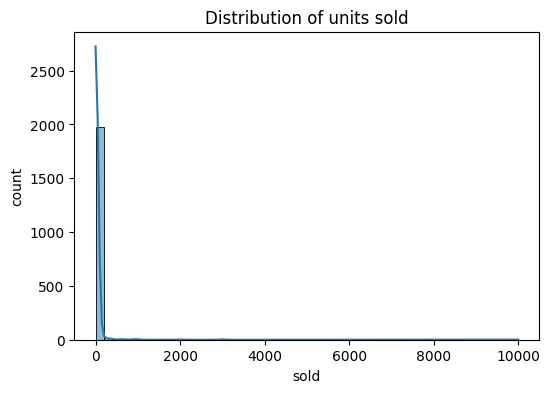

In [37]:
# ============================================
# 4. Exploratory Data Analysis (EDA)
# ============================================

4.1# Plot: distribution of sold
plt.figure(figsize=(6, 4))
sns.histplot(df["sold"], bins=50, kde=True)
plt.title("Distribution of units sold")
plt.xlabel("sold")
plt.ylabel("count")
plt.show()

In [38]:
4.2# Numeric stats for sold as table
sold_stats = df["sold"].describe().to_frame().T.reset_index(drop=True)
show_table("Sold summary statistics", sold_stats)


--- Sold summary statistics ---
 count    mean        std  min  25%  50%  75%     max
2000.0 23.4935 254.094061  0.0  1.0  3.0  9.0 10000.0
----------------------------------------


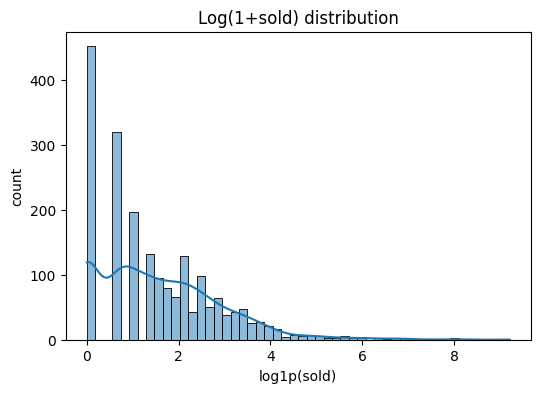

In [39]:
4.3# Log distribution
df["log_sold"] = np.log1p(df["sold"])
plt.figure(figsize=(6, 4))
sns.histplot(df["log_sold"], bins=50, kde=True)
plt.title("Log(1+sold) distribution")
plt.xlabel("log1p(sold)")
plt.ylabel("count")
plt.show()

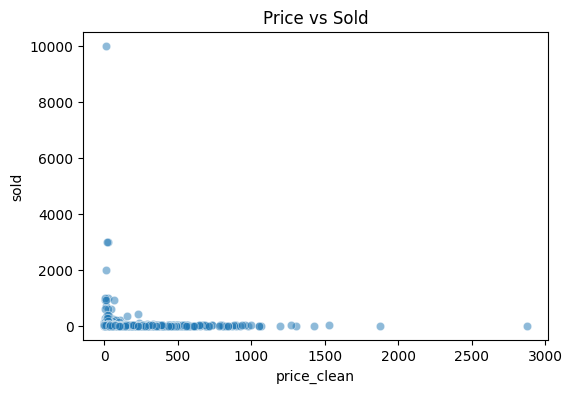

In [40]:
4.4# Price vs sold
plt.figure(figsize=(6, 4))
sns.scatterplot(x="price_clean", y="sold", data=df, alpha=0.5)
plt.title("Price vs Sold")
plt.xlabel("price_clean")
plt.ylabel("sold")
plt.show()


--- Correlation matrix (numeric features) ---
            Feature  originalPrice_clean  price_clean      sold
originalPrice_clean             1.000000     0.358316 -0.022343
        price_clean             0.358316     1.000000 -0.057584
               sold            -0.022343    -0.057584  1.000000
----------------------------------------


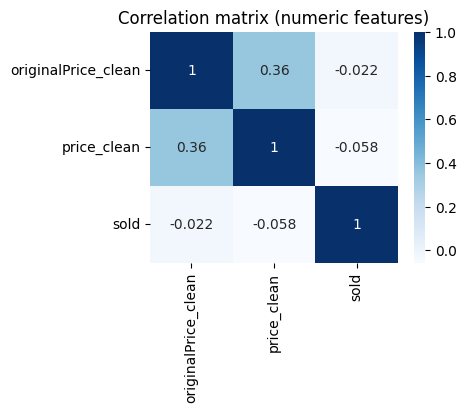

In [41]:
4.5# Correlation matrix (numeric)
num_cols = ["originalPrice_clean", "price_clean", "sold"]
corr = df[num_cols].corr()
corr_table = corr.reset_index().rename(columns={"index": "Feature"})
show_table("Correlation matrix (numeric features)", corr_table)

plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation matrix (numeric features)")
plt.show()

In [42]:
4.6# Top tagText by average sold (table)
tag_stats = (
    df.groupby("tagText")["sold"]
    .agg(count="count", avg_sold="mean")
    .sort_values("avg_sold", ascending=False)
    .head(10)
    .reset_index()
)
show_table("Top 10 tagText by avg sold", tag_stats)


--- Top 10 tagText by avg sold ---
           tagText  count  avg_sold
+Shipping: $109.18      1     405.0
+Shipping: $168.91      1     150.0
+Shipping: $225.12      1     118.0
 +Shipping: $29.45      1      87.0
  +Shipping: $2.91      2      83.0
+Shipping: $132.48      1      58.0
 +Shipping: $12.03      1      53.0
  +Shipping: $76.6      1      53.0
+Shipping: $140.27      1      42.0
 +Shipping: $23.29      1      41.0
----------------------------------------


In [ ]:


# ============================================
# 5. Prepare features and target
# ============================================
TARGET = "sold"
FEATURES = ["productTitle", "originalPrice_clean", "price_clean", "tagText"]

X = df[FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

shapes_table = pd.DataFrame(
    [
        {"Set": "X_train", "Rows": X_train.shape[0], "Cols": X_train.shape[1]},
        {"Set": "X_test", "Rows": X_test.shape[0], "Cols": X_test.shape[1]},
    ]
)
show_table("Train/Test shapes", shapes_table)

numeric_features = ["originalPrice_clean", "price_clean"]
categorical_text_features = ["tagText", "productTitle"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", max_categories=50),
         categorical_text_features),
    ]
)




In [32]:
# ============================================
# 6. Baseline model: Linear Regression
# ============================================
linreg_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)
linreg_model.fit(X_train, y_train)

y_pred_lr = linreg_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5
scores_lr = cross_val_score(linreg_model, X, y, cv=5, scoring="r2")

linreg_metrics = pd.DataFrame([{
    "Model": "Linear Regression",
    "R2": r2_score(y_test, y_pred_lr),
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "RMSE": rmse_lr,
    "CV_R2_mean": scores_lr.mean(),
    "CV_R2_std": scores_lr.std()
}])
show_table("Linear Regression metrics", linreg_metrics)





--- Linear Regression metrics ---
            Model       R2       MAE      RMSE  CV_R2_mean  CV_R2_std
Linear Regression 0.022202 24.810571 73.224151   -0.753477   1.480366
----------------------------------------


In [33]:
# ============================================
# 7. Tree-based model: Random Forest Regressor
# ============================================
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring="r2", n_jobs=-1)

rf_metrics = pd.DataFrame([{
    "Model": "Random Forest",
    "R2": r2_score(y_test, y_pred_rf),
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": rmse_rf,
    "CV_R2_mean": scores_rf.mean(),
    "CV_R2_std": scores_rf.std()
}])
show_table("Random Forest metrics", rf_metrics)

all_metrics = pd.concat([linreg_metrics, rf_metrics], ignore_index=True)
show_table("All model metrics", all_metrics)





--- Random Forest metrics ---
        Model        R2       MAE       RMSE  CV_R2_mean  CV_R2_std
Random Forest -5.085375 31.714853 182.672579   -2.601061   3.732875
----------------------------------------

--- All model metrics ---
            Model        R2       MAE       RMSE  CV_R2_mean  CV_R2_std
Linear Regression  0.022202 24.810571  73.224151   -0.753477   1.480366
    Random Forest -5.085375 31.714853 182.672579   -2.601061   3.732875
----------------------------------------


In [35]:
# ============================================
# 8. Predict for new sample
# ============================================
new_data = pd.DataFrame([{
    "productTitle": "Modern Wooden TV Stand with Storage Drawers",
    "originalPrice_clean": 199.99,
    "price_clean": 149.99,
    "tagText": "Free shipping",
}])

predicted_sold = rf_model.predict(new_data)

pred_table = new_data.copy()
pred_table["predicted_sold"] = predicted_sold
show_table("Prediction for new product", pred_table)


--- Prediction for new product ---
                               productTitle  originalPrice_clean  price_clean       tagText  predicted_sold
Modern Wooden TV Stand with Storage Drawers               199.99       149.99 Free shipping          29.195
----------------------------------------
